## Hot Rod in block Gauss-Seidel SDC
[Hot Rod](https://doi.org/10.1007/978-3-319-43659-3_47) is a detector for soft faults.
It works by performing two error estimates, subtracting them and comparing that to a threshold.
The first error estimate is the familiar embedded estimate (see the notes on adaptivity).
The second one is based on extrapolation.

### Extrapolation based error estimate
This idea is taken from [Butcher and Johnston](https://doi.org/10.1016/0377-0427(93)90275-G), who did this with Runge-Kutta schemes.
We combine values of the solution of previous time steps to extrapolate to the end of the current time step, while at the same time solving the current step as usual, which gives us two solutions and by subtracting them, we can get the error.

Let's start with how to do the extrapolation, which we will do with an idea very close to finite differences.
We do a Taylor expansion of the solution around the point where we are trying to estimate the error, $t$:
$$u(t-h) = u(t) - h u'(t) + \sum_{j=2}^n \frac{(-h)^j}{j!}u^{\left(j\right)}(t) + \mathcal{O}(h^{n+1}),$$
where the derivatives are in the time direction.
Notice how the solution appears only evaluated at time $t$ and the distance to $t$ only appears in the summands of the expansion as a prefactor to some power.
This means we can combine evaluations of the solution at different distances from the point around which we expand to get an arbitrary derivative to arbitrary order, provided we have enough values available.
This is preciely the finite difference idea.

However, we are doing a few things slightly differently from the usual finite difference computation.
First of all, we are interested in the solution itself, rather than a derivative, which is unnatural in the context of spatial discretization that finite differences are usually found in, but requires no conceptual change.
The larger difference is that we actually know the first derivative in time from evaluating the right hand side of the problem.
The derivative function is precisely what we put in as the problem to solve!

What we want looks like this:
$$u_{-1} = \sum_{j=2}^{n+1} \left( a_j u_{-j} + b_j f_{-j} \right) + \mathcal{O}\left(h^{n+2}\right),$$
where $u_{-j}$ and $f_{-j}$ are the solution and right hand side evaluations of the step $j-1$ steps ago and the coefficients $a_j$ and $b_j$ remain to be found.
We will tackle this problem by constructing a linear system $Ax=y$, which can easily be solved.
The matrix $A$ will contain the coefficients in front of the function evaluations in the Taylor expansion, where the row index corresponds to the derivative and the colum index corresponds to a step.
The solution vector $y$ will carry a one in the row of the derivative that we want to compute and the solution vector will carry the coefficients $a$ and $b$.
We will Taylor expand until the order that we want and we need just as many solutions or right hand side evaluations to get a system that we can solve.
$$A_{ij} = 
\begin{cases}
\frac{h_{-j}^{i}}{i!},& i < \frac{n}{2}\\
0,& i\geq\frac{n}{2}, j=1\\
\frac{h_{-j}^i}{(i-1)!},& otherwise,
\end{cases}$$
$$y_i = \delta_{i1},$$
$$a_j = x_{j}, b_j = x_{j+n/2}$$
$$h_{-1} = 0.$$
Here, the left half of $A$ corresponds to the solutions and the right half corresponds to the right hand side evaluations.
There is some mess with the indeces in the above formulae, which I appologise for!
I am trying to assume a starting index of one here.
Of course, some care must be taken if $n$ is uneven, but it is not conceptually difficult.
In the implementation in pySDC, we choose to set $b_{-n/2}=0$ to resolve this.

What do we put in for $n$ now?
We want to estimate the local error, which is order $k+1$, so we set $n=k+2$ to make sure the error introduced by the Taylor expansion is negligible compared to the error of time marching, which we want to estimate.

Now we have two solutions at the end of the current step, one computed by extrapolation and the other one by the time marching scheme.
If we subtract the two, only something like the local error remains.
But since both carry multiples of the local error, we need to fix a prefactor before we really get the local error.
Putting initial conditions into the time marching scheme produces the solution plus one times the local error, but the extrapolation method is based on multiple instances of time-marching-scheme produced solutions and their errors accumulate.
In a linear equation the error would just sum up: The solution after three steps comes with three times the local error, but we have two complications.
The first one is adaptivity: With changing step size, the local error introduced while solving each step is different and the second one is non-linearity of equations.
For non-linear equations, there is really not much we can do.
The prefactor will be slightly off.
But for adaptivity, we can provide a kind of fix, which only works when the time scale of the problem doesn't change quickly, which is the following:$$e_{-j}\approx \left(\frac{h_{-1}}{h_{-j}}\right)^{k+1}e_{-1}.$$
Keep in mind that in our weird notation $e_{-1}$ is the local error of the current step.
We can then compute the prefactor as
$$\mathcal{P} = 1/\mid \sum_{j=1}^{n+1} \left(\sum_{i=1}^{n-j} \left(\frac{h_{-i}}{h_{-1}}\right)^{k+1}\right) a_j - 1\mid,$$
where the inner sum is the accumulated error carried by each solution and the outer sum gathers the contributions of all participating solutions as they enter in the extrapolation.
The $-1$ is for the contribution of the solution obtained by time marching.

Now, we have all we need:
$$\epsilon_{extrapolation} = \mathcal{P}\left(\sum_{j=2}^{n+1} a_j u_{-j} + b_j f_{-j} - u_{-1}\right)$$
And now we have an estimate for the local error that is based on something else than the embedded method, so we can compare.
But this method has several complicating aspects.
First of all, we introduce severe memory overhead, since we don't just need the solution in memory, but additional quantities that total $k+1$ times the size in memory as the solution.
Second, we already mentioned that with non-linear equations, this method loses some accuracy because the underlying ideas in computing the prefactor are only valid for linear equations.

Finally, we estimate here the error of the last sweep, which is good, but if we want to compare to the error of the second to last sweep that we get from the embedded method, it turns out we actually need to advance in time with the second to last sweep as well.
Just storing the second to last sweep for extrapolation and advancing with the last sweep has yielded an error estimate of the order of the last sweep, so this is not a valid solution.
This means, however, that on top of the significant memory overhead, we now also get significant computational overhead since we need to perform an extra sweep which we then throw away.
This only applies when using this estimate for comparing to the embedded estimate, however.

### Hot Rod resilience strategy
As discussed in the above paragraph, Hot Rod is not without its flaws, but we can actually construct a rather resilient fault detector from this.
We now take the difference of the two error estimates that we obtained and this should be one order higher than the estimates themselves:
$$\Delta = \|\epsilon_\mathrm{embedded} - \epsilon_\mathrm{extrapolation}\| = \|e + \mathcal{O}\left(h^{k+1}\right) - e + \mathcal{O}\left(h^{k+1}\right)\| = \mathcal{O}\left(h^{k+1}\right).$$
Now it's as simple as comparing this to a threshold and restarting whenever this threshold is exceeded.

### Tests
We will look at the Pi-line problem here, which models an electrical startup process and is a simple but not too boring equation.
Let's run this and look at what the error estimates give us:

In [1]:
import matplotlib.pyplot as plt
from piline import run_piline, get_data, plot_solution, plot_error
from pySDC.implementations.convergence_controller_classes.adaptivity import Adaptivity
from pySDC.implementations.convergence_controller_classes.hotrod import HotRod

matplotlib.font_manager - WARNING: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
matplotlib.font_manager - WARNING: findfont: Generic family 'sans-serif' not found because none of the following families were found: 
matplotlib.font_manager - WARNING: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
matplotlib.font_manager - WARNING: findfont: Generic family 'sans-serif' not found because none of the following families were found: 


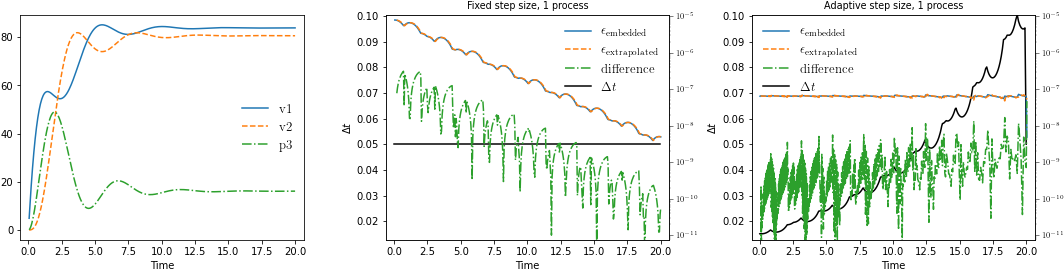

In [2]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharex=True)

# define parameters for convergence controllers
adaptivity_params = dict()
adaptivity_params['e_tol'] = 1e-7

hotrod_params = dict()
hotrod_params['HotRod_tol'] = 1.  # this will not be useful for resilience, but this is just a test

convergence_controllers = dict()
convergence_controllers[HotRod] = hotrod_params

description = dict()
description['convergence_controllers'] = convergence_controllers

# run without adaptivity
data = get_data(run_piline(description, 1))
plot_solution(data, axs[0])
plot_error(data, axs[1], False)
axs[1].set_title('Fixed step size, 1 process')

# run with adaptivity by adding it to the convergence controllers
convergence_controllers[Adaptivity] = adaptivity_params
data = get_data(run_piline(description, 1))
plot_error(data, axs[2], True)
axs[2].set_title('Adaptive step size, 1 process')

fig.tight_layout()
plt.show()

The Pi-line equation is a linear ordinary differential equation with three components, that are approaching a fixed state over time, which you can see in the left panel.
The other panels show the error and the difference, which is used for detecting soft faults, as well as the time step size in black.

As the solution approaches the fixed state, the time scale of the problem gets longer, which means when we keep the step size fixed, the error goes down, like in the middle plot.
Since this means we cannot chose a sensible detection threshold as you either restart unaffected steps in the beginning or don't catch faults later on, we would prefer to combine Hot Rod with adaptivity, which you can see in the right panel.

### Parallel-in-time Hot Rod
With block Gauss-Seidel SDC, we can extend Hot Rod to PinT rather easily.
It is important to know the order of the scheme, which is why we only have an implementation for block Gauss-Seidel and not for other flavors of PinT SDC so far and only for fixed numbers of iterations.

The simplest extension is to use steps that are computed on different processes for the extrapolation instead of keeping them in memory and to do nothing else.
Meaning not changing the prefactor or anything like that.
This has the major advantage of eliminating the memory overhead, since we have the solutions in memory anyways.
The disadvantage is that we get a start-up phase in every block.
We can only extrapolate when we have sufficiently many solutions available after all, which is in fact also why we use the right hand side evaluations to cut this is in half.
For a scheme with $k$ iterations, we do a Taylor expansion up to order $k+2$, which means we need $k/2+1$ solutions to steps in memory, but after that we can extrapolate every step in the block.

Let's see how this looks in practice:

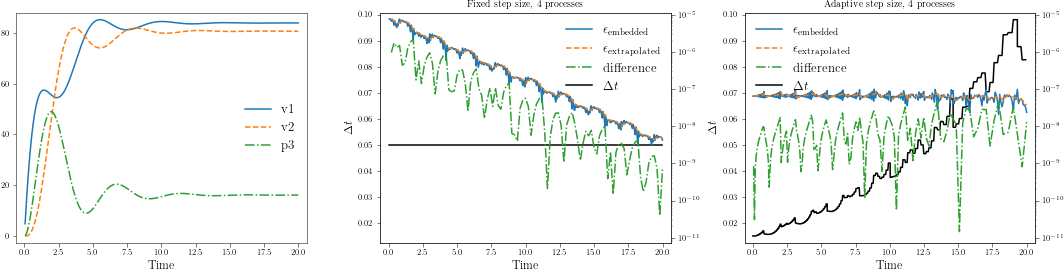

In [3]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharex=True)

# define parameters for convergence controllers
adaptivity_params = dict()
adaptivity_params['e_tol'] = 1e-7

hotrod_params = dict()
hotrod_params['HotRod_tol'] = 1.  # this will not be useful for resilience, but this is just a test
hotrod_params['no_storage'] = True

convergence_controllers = dict()
convergence_controllers[HotRod] = hotrod_params

description = dict()
description['convergence_controllers'] = convergence_controllers

# run without adaptivity
data = get_data(run_piline(description, 4))
plot_solution(data, axs[0])
plot_error(data, axs[1], False)
axs[1].set_title('Fixed step size, 4 processes')

# run with adaptivity by adding it to the convergence controllers
convergence_controllers[Adaptivity] = adaptivity_params
data = get_data(run_piline(description, 4))
plot_error(data, axs[2], True)
axs[2].set_title('Adaptive step size, 4 processes')

fig.tight_layout()
plt.show()

As you can see, Hot Rod still works with this minimal effort PinT extension, but the difference between the error estimates and $\Delta$ is significantly smaller.
Maybe, the prefactor can be refined to make Hot Rod more efficient again.

### Verifying the order in time of the error estimates

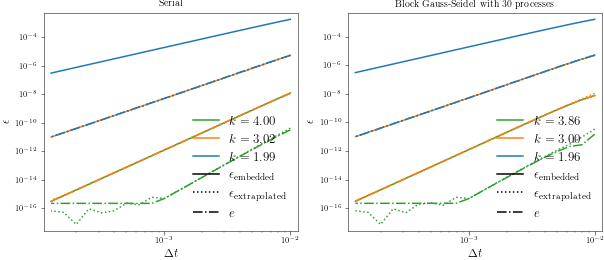

In [4]:
from accuracy_check import plot_all_errors
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
ks = [4, 3, 2]
axs[0].set_title('Serial')
plot_all_errors(axs[0], ks, serial=True)
axs[1].set_title('Block Gauss-Seidel with 30 processes')
plot_all_errors(axs[1], ks, serial=False)

Since we don't have an analytic solution, we compute the "true" error $e$ using very accurate solutions obtained with `scipy.solve_ivp` as reference solutions.
You can see the following things: The order of the error of the embedded method is equal to the sweep count, while the order of the error of the extrapolated and "true" errors are one higher.
This is exactly what we expected.
Also, they match up in magnitude very well when comparing errors of the same order (not the same sweep count), which is why Hot Rod works.
The new information in this plot compared to earlier plots is that the error estimates also have a sensible magnitude and don't just match up by coincidence.
We plot here the error after 30 fixed-size time steps, which is also the processor count in the time-parallel plot on the right.
The blue, orange and green lines are from runs with 2, 3 and 4 sweeps respectively, while the labels in the plot mark the measured order of the embedded estimate.

### How can you use Hot Rod with pySDC?
Hot Rod is implemented as convergence controller, which you can import from
```
from pySDC.implementations.convergence_controller_classes.hotrod import HotRod
```
Then, you need to set two parameters.
The first one is the tolerance for triggering restarts called `HotRod_tol`.
We set this to 1 earlier because we just wanted to verify that the error estimators behave as they should, but in practice you would set this just above the typical difference in the fault free case.

The second parameter is called `no_storage` and contains whether you want to use the implementation with memory overhead, which you should do in the serial case, or without, which you should do in parallel, but make sure you have sufficiently many processes.
This is set to `False` by default, so you might leave this out if you stay serial.

You should end up with something like this in your code:
```
hotrod_params = dict()
hotrod_params['HotRod_tol'] = <float>
hotrod_params['no_storage'] = <bool>

convergence_controllers = dict()
convergence_controllers[HotRod] = hotrod_params

description = dict()
description['convergence_controllers'] = convergence_controllers
```

To use Hot Rod successfully, you need to satisfy the same requirements for a fixed and known order as in adaptivity, so refer to that notebook for how to do that.
It is also recommended to use adaptivity in conjunction with Hot Rod anyways.
See the above example for how to add both convergence controllers.

To record the error estimates, simply put the following in the `post_step` hook:
```
self.add_to_stats(process=step.status.slot, time=L.time + L.dt, level=L.level_index, iter=0,
                  sweep=L.status.sweep, type='e_embedded', value=L.status.error_embedded_estimate)
self.add_to_stats(process=step.status.slot, time=L.time + L.dt, level=L.level_index, iter=0,
                  sweep=L.status.sweep, type='e_extrapolated', value=L.status.error_extrapolation_estimate)
```